# Workshop Preperation for Classiq's Challenge - Quantum Arithmetic

Welcome to the Classiq challenge of the 2024 MIT IQuHack hackathon!
This Jupyter notebook is a tutorial workshop that should prepare you for the challenge itself.


Additional resources you should use are
- The IDE of the classiq platform at [platform.classiq.io](platform.classiq.io)
- The [community Slack of Classiq](https://short.classiq.io/join-slack) - Classiq's team will answer any question you have over there, including implementation questions
- [Classiq's documentation](https://docs.classiq.io/latest/user-guide/platform/) with the dedicated [Python SDK explanations](https://docs.classiq.io/latest/user-guide/platform/qmod/python/functions/)

Good luck!

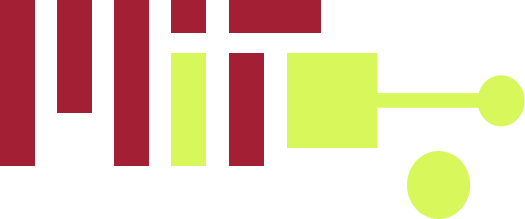

## Setting The Scene

Install the Classiq SDK package:

In [ ]:
!pip install -U classiq

You need to authenticate your device in order to use Classiq's backend synthesis engine and IDE. Make sure to register to the platform at [platform.classiq.io](platform.classiq.io) before you run the next cell:

In [ ]:
import classiq
classiq.authenticate()

In [2]:
from classiq import *

## A Warm Up

### First Example

Write a function that prepares the minus state $\ket{-}=\frac{1}{\sqrt2}(\ket{0}-\ket{1})$, assuming it recives the qubit $\ket{x}=\ket{0}$ (hint: 

<details>
<summary>
HINT
</summary>

Use `H(x)`,`X(x)`
</details>

In [ ]:
@QFunc
def prepare_minus_state(x:QBit):
    pass #TODO delete pass
    #TODO prepare |-> function

Now we will test our code:

In [ ]:
@QFunc
def main(x: Output[QBit]):
    allocate(1,x) # Initialize the qubit x
    pass #TODO delete pass
    #TODO apply the function prepare_minus

In [ ]:
quantum_model = create_model(main)
quantum_program = synthesize(quantum_model)

In [ ]:
show(quantum_program)

### Uniform Superposition

Let's continue warming up with creating a function that receives a quantum register and creates a uniform superposition for all qubits within this array. You should use the function `apply_to_all(gate_operand=, target=)`:

In [ ]:
@QFunc
def create_initial_state(reg: QArray[QBit]):
    pass #TODO delete pass
    #TODO use the function apply_to_all in order create a uniform superposition

Test your function by creating a new main function, synthesizing and viewing the circuit:

In [ ]:
@QFunc
def main(): #TODO fill in the correct declaration here, what variables this model should output?
    pass #TODO delete pass
    #TODO allocate reg with a few qubits
    create_initial_state(reg)

In [ ]:
qprog = synthesize(create_model(main))
#TODO show the quantum program

## Guidelines for High-Level Functional Design with Classiq

Some basic explanations about the high-level functional design with Classiq:

* There should always be a main (`def main(...)`) function - the model that captures your algorithm is described there

* The model is always generated out of the main function 

* The model is sent to the synthesis engine (compiler) that return a quantum program which contains the quantum circuit

Some basic guidelines about the modeling language (QMOD):

1. Every quantum variable should be declared, either as an argument of a function e.g. `def prepare_minus(x: QBit)` or as a local variable within the function itself with `x = QBit('x')`

2. Some quantum variables need to be initialized with the `allocate` function. This is required in 2 cases:
* A variable is an argument of a function with the declaration `Output` like `def main(x: Output[QInt])`
* A variable that was declared within a function like `a = QInt('a')`

3. For the `main` function, you will always use `Output` for all variables.

4. Every function you use with the QMOD language should have the decorator `@QFunc` before it

Important tip!

You can see all the declarations of the functions with what are their input arguments in the `functions.py` file within the classiq package (or by just right clicking a function and pressing `Go To Definition`)

## Tutorial - Arithmetic Operations with Classiq

One of the key advantages of Classiq is it's simplistic and powerful compiler for quantum arithmetic. Let's see an example:

In [6]:
num_qubits = 4
fraction_digits = 0 
is_signed = True

@QFunc
def main(x: Output[QNum], y: Output[QNum]):
    allocate_num(num_qubits=num_qubits, is_signed=is_signed, fraction_digits=fraction_digits, out=x)
    hadamard_transform(x)
    y|= x**2 + 1

qmod = create_model(main)

The `allocate_num` function initializes a quantum variable that represent numbers. By default, it is initialized to the $\ket{0}$ state. Then the `hadmard_transform` creates a superposition of all possible states in the domain $[-2^3,2^3-1]$. Finally, the arithmetic operation creates the entangled superposition of states:
$\begin{equation}
\sum_{x =-2^3}^{2^3-1}\ket{x}\ket{x^2+1}.
\end{equation}$

The `qmod` variable is a string that captures the algorithm we have just created in a JSON format. Now, what we want is to synthesize (compile) in order to receive a concrete quantum program that contains the quantum circuit implementation.

In [ ]:
qprog = synthesize(qmod)

And in order to view it:

In [ ]:
show(qprog)

## Advanced Arithmetics

Now let's create a general linear function with Classiq: $y= ax+b$ where $a,b$ are classical integer parameters and $x,y$ is a quantum states representing integers:

In [3]:
@QFunc
def linear_func(a:QParam[int],b: QParam[int], x:QNum, y: Output[QNum]):
    y |= a*x+b

In [4]:
@QFunc
def main(x:Output[QNum], y: Output[QNum]):

    a = 2
    b = 1
    allocate_num(num_qubits=4,is_signed=False,fraction_digits=0,out=x)
    hadamard_transform(x)
    linear_func(a,b,x,y)

qmod = create_model(main)

In [ ]:
qprog = synthesize(qmod)

Let's execute the circuit from directly from the SDK:

In [ ]:
job = execute(qprog)

And we can view the results in the IDE:

In [ ]:
job.open_in_ide()

Or to directly analyze it within the SDK:

In [ ]:
results = job.result()
parsed_counts = results[0].value.parsed_counts
for sampled_state in parsed_counts: print(sampled_state.state)

Now it's your turn! Implement the same linear function, but now $x$ is in the domain $[0,1)$ and is represented by 4 qubits. The parameters $a,b$ should be now `float` with the values of: $a=0.5, b=1.5$.

In [ ]:
#TODO complete here

## Tutorial - Two controlled Linear operations

Let's say we want now to have two linear operations applied on the same quantum variable (register). But the arithmetic operation initialize a new quantum variable, so how can we do that? The answer is that we need to apply the operation to another variable and then XOR it to the variable we want. 

This can be useful if the linear operation we want to apply is controlled upon a control variable. Let's first define the functional building block:

In [10]:
@QFunc
def inplace_linear_attempt(a:QParam[int],b: QParam[int], x:QNum, y: QNum):
    tmp = QNum('tmp')
    linear_func(a,b,x,tmp)
    inplace_xor(tmp,y)

And checking our basic function implementation:

In [11]:
@QFunc
def main(x: Output[QNum],y: Output[QNum]):
    a = 1
    b = 2

    allocate_num(4,False,0,y)
    allocate_num(4,False,0,x)
    hadamard_transform(x)
    inplace_linear_attempt(a,b,x,y)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/6d0b2a8f-801e-444d-ad9d-34deb8a9095a?version=0.36.1


OK, cool. So now we want to add a control qubit that controlled on the state $\ket{0}$ implements the linear function $\ket{x}\rightarrow\ket{x}\ket{x+2}$ and controlled on the state $\ket{1}$ implements the linear function $\ket{x}\rightarrow\ket{x}\ket{2x+1}$:

In [25]:
@QFunc
def control_logic(a: QParam[list[int]], b: QParam[list[int]], controller:QNum, x: QNum, y: QNum):
    
    repeat( count=a.len(),         
            iteration=lambda i: quantum_if(controller==i, lambda: inplace_linear_attempt(a[i],b[i],x,y)))


In [26]:
@QFunc
def main(controller: Output[QNum], x: Output[QNum],y: Output[QNum]):

    # Linear polynom parameters
    a = [1,2]
    b = [2,1]

    # Initializing x to a superposition in the domain [0,2^4-1]
    allocate_num(4,False,0,x)
    hadamard_transform(x)
    
    #Initialize y
    allocate_num(4,False,0,y)

    # Setting the controller in a superposition
    allocate_num(1,False,0,controller)
    H(controller)

    # Implementing the control logic
    control_logic(a,b,controller,x,y)

    
qmod = create_model(main)

In [ ]:
qprog = synthesize(qmod)
show(qprog)

By executing we can actually see we get what we want:

In [19]:
def print_parsed_counts(job):
    results = job.result()
    parsed_counts = results[0].value.parsed_counts
    for parsed_state in parsed_counts: print(parsed_state.state)

job = execute(qprog)
print_parsed_counts(job)

{'controller': 1.0, 'x': 4.0, 'y': 9.0}
{'controller': 0.0, 'x': 12.0, 'y': 14.0}
{'controller': 1.0, 'x': 12.0, 'y': 9.0}
{'controller': 0.0, 'x': 15.0, 'y': 1.0}
{'controller': 0.0, 'x': 1.0, 'y': 3.0}
{'controller': 1.0, 'x': 3.0, 'y': 7.0}
{'controller': 0.0, 'x': 3.0, 'y': 5.0}
{'controller': 1.0, 'x': 2.0, 'y': 5.0}
{'controller': 1.0, 'x': 8.0, 'y': 1.0}
{'controller': 0.0, 'x': 8.0, 'y': 10.0}
{'controller': 0.0, 'x': 14.0, 'y': 0.0}
{'controller': 1.0, 'x': 9.0, 'y': 3.0}
{'controller': 1.0, 'x': 7.0, 'y': 15.0}
{'controller': 0.0, 'x': 11.0, 'y': 13.0}
{'controller': 1.0, 'x': 13.0, 'y': 11.0}
{'controller': 0.0, 'x': 2.0, 'y': 4.0}
{'controller': 1.0, 'x': 6.0, 'y': 13.0}
{'controller': 1.0, 'x': 11.0, 'y': 7.0}
{'controller': 1.0, 'x': 1.0, 'y': 3.0}
{'controller': 0.0, 'x': 6.0, 'y': 8.0}
{'controller': 0.0, 'x': 5.0, 'y': 7.0}
{'controller': 0.0, 'x': 4.0, 'y': 6.0}
{'controller': 0.0, 'x': 0.0, 'y': 2.0}
{'controller': 1.0, 'x': 5.0, 'y': 11.0}
{'controller': 0.0, 'x': 1

Of course there is the issue of rounding and overflow - when one tries to represent $2*15+1=31$ with $4$ binary digits that's not possible (because the domain $[0,31]$ of integers is represented by at least 5 bits). See our [documentation](https://docs.classiq.io/latest/user-guide/platform/qmod/python/quantum-expressions/#inplace-arithmetic-operators) for further explanations.

Let's try to use Classiq and optimize the circuit for minimal circuit width:

In [20]:
def print_depth_width(quantum_program):
    generated_circuit = GeneratedCircuit.parse_raw(quantum_program)
    print(f"Synthesized circuit width: {generated_circuit.data.width}, depth: {generated_circuit.transpiled_circuit.depth}")

qmod = set_constraints(qmod,Constraints(optimization_parameter='width'))
qprog = synthesize(qmod)
print_depth_width(qprog)

Synthesized circuit width: 20, depth: 688


And when optimizing for depth:

In [22]:
qmod = set_constraints(qmod,Constraints(optimization_parameter='depth'))
qprog = synthesize(qmod)
print_depth_width(qprog)

Synthesized circuit width: 32, depth: 398


Firstly, we can see here a clear demonstration of the power of high-level functional design! The same algorithm with the same functionality was optimized once for depth and once for width and the result is 2 different circuits with different characteristics that implement the same functionality.

Secondly, is this the best we can do? Obviously the Classiq synthesis engine is optimizing for us the algorithm quite good. But, can we change something with our functionality, with our algorithm to get more efficient circuits? 

If we go back to out `inplace_linear_attempt` function, we can see that we initialize a `tmp` variable that requires more qubits and is not used. For such scenarios we have the `within_apply`. This logic implements sort of $UVU^{\dagger}$ and when temporary variables are outputs of $U$ and used only by $V$ they are uncomputed by $U^{\dagger}$. Let's see for our example:

In [30]:
@QFunc
def inplace_linear_func(a:QParam[int],b: QParam[int], x:QNum, y: QNum):
    tmp = QNum('tmp')
    within_apply(compute= lambda: linear_func(a,b,x,tmp),
                action= lambda: inplace_xor(tmp,y))

With the new `control_logic`:

In [31]:
@QFunc
def control_logic_2(a: QParam[list[int]], b: QParam[list[int]], controller:QNum, x: QNum, y: QNum):
    
    repeat( count=a.len(),         
            iteration=lambda i: quantum_if(controller==i, lambda: inplace_linear_func(a[i],b[i],x,y)))

And when we put all together now:

In [32]:
@QFunc
def main(controller: Output[QNum], x: Output[QNum],y: Output[QNum]):

    # Linear polynom parameters
    a = [1,2]
    b = [2,1]

    # Initializing x to a superposition in the domain [0,2^4-1]
    allocate_num(4,False,0,x)
    hadamard_transform(x)
    
    #Initialize y
    allocate_num(4,False,0,y)

    # Setting the controller in a superposition
    allocate_num(1,False,0,controller)
    H(controller)

    # Implementing the control logic
    control_logic_2(a,b,controller,x,y)

    
qmod = create_model(main)

In [33]:
qprog = synthesize(qmod)

In [34]:
show(qprog)

Opening: https://platform.classiq.io/circuit/c5d18fda-ab8b-42b8-8373-4a57c49283db?version=0.36.1


And now when we optimize for width:

In [35]:
qmod = set_constraints(qmod,Constraints(optimization_parameter='width'))
qprog = synthesize(qmod)
print_depth_width(qprog)

Synthesized circuit width: 16, depth: 244


And for depth:

In [36]:
qmod = set_constraints(qmod,Constraints(optimization_parameter='depth'))
qprog = synthesize(qmod)
print_depth_width(qprog)

Synthesized circuit width: 45, depth: 203


So using the `within_apply` logic enabled us to reduce the optimal circuit implementation in terms of width from $20$ to $16$ and the optimal circuit depth from $398$ to $203$! I think both can be useful for you for the hackathon :) 

## Cheat Sheet

### Initalizations

In [ ]:
allocate(
    num_qubits: QParam[int],
    out: Output[QArray[QBit, Literal["num_qubits"]]])
    '''
    x = QArray('x')
    allocate(4,x)
    '''

allocate_num(
    num_qubits: QParam[int],
    is_signed: QParam[bool],
    fraction_digits: QParam[int],
    out: Output[QNum])
'''
x = QNum('x')
allocate_num(4,False,4,x)
'''

### Operations

In [ ]:
repeat(
    count: QParam[int],
    iteration: QCallable[QParam[int]],
)
'''
x = QArray
allocate(4,x)
repeat(x.len(),lambda index: H(x))
'''

control(
    operand: QCallable,
    ctrl: QArray[QBit],
) 
'''
x = QArray('x')
y = QArray('y')
x = allocate(4,x)
y = allocate(4,y)
repeat(x.len(),lambda i: control(lambda: X(y[i]),x[i]))
'''